# Second Part Mini-Project - Graph Embeddings
> Kristof Balazs <br />
> Stefanos Kypritidis <br />

### Instructions

The first code cell lists all the libraries that need to be installed if you want to run the analysis.
The second code cell contains the utils file (over 1000 lines of code), which includes all helper functions used throughout the notebook. **For readability, it is recommended to keep this cell collapsed**. You can expand it at any time to review the implementations of the algorithms and visualizations used in the analysis.

In [24]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import urllib.request
import gzip
import shutil
import zipfile
from sklearn.metrics import adjusted_rand_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.decomposition import PCA
from node2vec import Node2Vec as N2V_Algo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
import random
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings('ignore')

# DATA DOWNLOADING FUNCTIONS

def download_data(folder_name, base_url, files, category):
    os.makedirs("data", exist_ok=True)

    target_dir = os.path.join("data", folder_name)
    os.makedirs(target_dir, exist_ok=True)

    if category == 'email':
        for fname in files:
            url = base_url + fname
            dest_gz = os.path.join(target_dir, fname)
            dest_txt = dest_gz.replace(".gz", "")

            print(f"Downloading {fname}...")
            urllib.request.urlretrieve(url, dest_gz)

            print(f"Extracting {fname}...")
            with gzip.open(dest_gz, "rb") as f_in:
                with open(dest_txt, "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)

            os.remove(dest_gz)

            print(f"Saved extracted file to {dest_txt}\n")

        print("Email core files downloaded and extracted successfully.")

    elif category == 'twitch':
        for fname in files:
            url = base_url + fname
            dest_zip = os.path.join(target_dir, fname)

            print(f"Downloading {fname}...")
            urllib.request.urlretrieve(url, dest_zip)

            print(f"Extracting PTBR files from {fname}...")
            with zipfile.ZipFile(dest_zip, 'r') as z:
                for member in z.namelist():
                    if member.startswith("__MACOSX/") or os.path.basename(member).startswith("._"):
                        continue

                    for target_file in ["musae_PTBR_edges.csv", "musae_PTBR_target.csv"]:
                        if member.endswith(target_file):
                            print(f"Extracting {member}...")
                            source = z.open(member)
                            dest_path = os.path.join(target_dir, target_file)
                            with open(dest_path, "wb") as f_out:
                                shutil.copyfileobj(source, f_out)
            #os.remove(dest_zip)
        print("Twitch PTBR files downloaded and extracted successfully.")


def generic_show(graph, node_color, node_size, node_tooltip, k_core=3, layout_func=nx.spring_layout, width=400, height=400):
    G = nx.k_core(graph, k=k_core)
    pos = layout_func(G)
    chart = nxa.draw_networkx(
        G=G,
        pos=pos,
        width=0.1,
        alpha=0.8,
        node_color=node_color,
        node_size=node_size,
        node_tooltip=node_tooltip
    )

    chart.properties(width=width, height=height).interactive().show()

def generic_show_static(graph, node_color=None, node_size=15, k_core=3, layout_func=nx.spring_layout, width=10, height=10):
    G = nx.k_core(graph, k=k_core)
    if len(G.nodes) == 0:
        print(f"Resulting graph is empty (no nodes with k-core >= {k_core})")
        return

    pos = layout_func(G)

    final_sizes = []
    if isinstance(node_size, (int, float)):
        final_sizes = [node_size for _ in G.nodes()]
    elif isinstance(node_size, str):
        raw_sizes = [G.nodes[n].get(node_size, 1) for n in G.nodes()]
        min_s, max_s = min(raw_sizes), max(raw_sizes)
        if max_s == min_s:
            final_sizes = [300 for _ in raw_sizes]
        else:
            final_sizes = [50 + ((x - min_s) / (max_s - min_s)) * 450 for x in raw_sizes]

    sm = None
    legend_handles = []

    raw_colors = [G.nodes[n].get(node_color, 0) for n in G.nodes()]
    unique_vals = sorted(list(set(raw_colors)))

    is_continuous = len(unique_vals) > 10 or (len(unique_vals) > 0 and isinstance(unique_vals[0], float))

    if is_continuous:
        cmap = plt.cm.viridis
        norm = mcolors.Normalize(vmin=min(raw_colors), vmax=max(raw_colors))
        final_colors = [cmap(norm(val)) for val in raw_colors]
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
    else:
        cmap = plt.cm.tab20 if len(unique_vals) > 10 else plt.cm.tab10
        val_to_color = {val: cmap(i) for i, val in enumerate(unique_vals)}
        final_colors = [val_to_color[val] for val in raw_colors]
        for val, color in val_to_color.items():
            legend_handles.append(mpatches.Patch(color=color, label=str(val)))

    fig, ax = plt.subplots(figsize=(width, height))

    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.4, width=0.1, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=final_colors, node_size=final_sizes, alpha=0.75)

    if is_continuous:
        cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
        cbar.set_label(node_color)
    else:
        ax.legend(handles=legend_handles, title=node_color, loc='best')

    ax.axis('off')
    plt.show()

# GRAPH LOADING FUNCTIONS

def load_email(directed=False):
    edge_list_path = 'data/email/email-Eu-core.txt'
    nodes_labels_path = 'data/email/email-Eu-core-department-labels.txt'

    G = nx.read_edgelist(edge_list_path,
                         delimiter=' ',
                         nodetype=int,
                         create_using=nx.DiGraph)

    if not directed:
        G = G.to_undirected()

    df_labels = pd.read_csv(
        nodes_labels_path,
        sep=' ',
        names=['node', 'department_id']
    )

    ground_truth_dict = pd.Series(
        df_labels.department_id.values,
        index=df_labels.node
    ).to_dict()

    nx.set_node_attributes(G, ground_truth_dict, 'ground_truth')
    G.remove_edges_from(nx.selfloop_edges(G))

    isolates = list(nx.isolates(G))
    G.remove_nodes_from(isolates)

    return G

def load_twitch_user_attributes(G):
    df = pd.read_csv("data/twitch/musae_PTBR_target.csv")
    attr_dict = {
        row["new_id"]: {
            "id": row["new_id"],
            "account_age_days": row["days"],
            "is_mature": row["mature"],
            "total_views": row["views"],
            "is_partner": row["partner"],
        }
        for _, row in df.iterrows()}

    df = df[["days", "mature", "views", "partner", "new_id"]].rename(columns={"new_id": "id",
                                            "days": "account_age_days", "mature": "is_mature",
                                            "views": "total_views", "partner": "is_partner"}).copy()
    nx.set_node_attributes(G, attr_dict)
    return G, df

def load_twitch_robust():
    print("--- Loading Twitch Data (Robust Method) ---")
    
    # Load Edges (skipping header automatically via pandas)
    df_edges = pd.read_csv("data/twitch/musae_PTBR_edges.csv")
    G = nx.from_pandas_edgelist(df_edges, source='from', target='to')
    
    # Load Targets/Attributes
    df_targets = pd.read_csv("data/twitch/musae_PTBR_target.csv")
    
    # Create Attribute Dictionary
    # We map 'new_id' (which matches the edge list) to the attributes
    attr_dict = {}
    for _, row in df_targets.iterrows():
        node_id = int(row['new_id'])
        
        # Convert True/False to 1/0 for easier plotting
        is_mature = 1 if row['mature'] == True else 0
        is_partner = 1 if row['partner'] == True else 0
        
        attr_dict[node_id] = {
            "days": row['days'],
            "views": row['views'],
            "partner": is_partner,
            "mature": is_mature,
            "ground_truth": is_mature 
        }
        
    # Apply attributes to the graph
    nx.set_node_attributes(G, attr_dict)
    
    # Remove nodes that might exist in edges but not in target list (if any)
    # or nodes in target list but not in edges (isolates)
    valid_nodes = set(attr_dict.keys())
    nodes_to_remove = [n for n in G.nodes() if n not in valid_nodes]
    if nodes_to_remove:
        print(f"Removing {len(nodes_to_remove)} nodes without attributes.")
        G.remove_nodes_from(nodes_to_remove)
        
    return G

# UTILITY / STATS FUNCTIONS

def summary_stats(graph):
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")
    
    degrees = [d for n, d in graph.degree()]
    avg_degree = sum(degrees) / graph.number_of_nodes()
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Density: {nx.density(graph):.4f}")

    if nx.is_connected(graph):
        print("Graph is connected.")
    else:
        num_components = nx.number_connected_components(graph)
        print(f"Graph is not connected. It has {num_components} connected components.")
        largest_cc = max(nx.connected_components(graph), key=len)
        print(f"Largest Component Size: {len(largest_cc)} nodes")

def get_spectral_embedding(G, dim=16, seed=42):
    """
    Implements Laplacian Eigenmaps.
    Uses the spectral properties of the Laplacian matrix L = D - A.
    """
    print(f"   > Computing Spectral Embedding (d={dim})...")
    
    # Adjacency matrix is A. SpectralEmbedding computes eigenvalues of L.
    # We use 'precomputed' affinity if we passed a matrix, but here we pass the graph.
    # The default affinity='nearest_neighbors' constructs the adjacency.
    adj = nx.to_scipy_sparse_array(G)
    
    # Solving the optimization problem for eigenvectors
    se = SpectralEmbedding(n_components=dim, affinity='precomputed', random_state=seed)
    embeddings = se.fit_transform(adj)
    
    return embeddings

def get_node2vec_embedding(G, dim=16, p=1.0, q=1.0, walks=10, length=80, seed=42):
    """
    Implements Node2Vec.
    Uses biased random walks (p, q) and Skip-Gram.
    """
    print(f"   > Computing Node2Vec Embedding (d={dim}, p={p}, q={q})...")
    
    # Preprocessing transition probs
    node2vec_model = N2V_Algo(
        G, 
        dimensions=dim, 
        walk_length=length, 
        num_walks=walks, 
        p=p, # Return parameter
        q=q, # In-out parameter
        workers=1, # Keep 1 for reproducibility
        quiet=True,
        seed=seed
    )
    
    # Random Walk & Training (Skip-Gram with Negative Sampling)
    model = node2vec_model.fit(window=10, min_count=1, batch_words=4)
    
    # Extract embeddings in correct node order
    nodes = list(G.nodes())
    embeddings = np.array([model.wv[str(n)] for n in nodes])
    
    return embeddings

def visualize_embeddings_side_by_side(G, emb_spectral, emb_n2v, title_prefix, ground_truth_attr='ground_truth'):
    """
    Reduces dimensions to 2D (using t-SNE) and plots side-by-side.
    t-SNE for visualization.
    """
    nodes = list(G.nodes())
    labels = [G.nodes[n].get(ground_truth_attr) for n in nodes]
    
    # Reduce to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    
    print(f"   > Projecting to 2D using t-SNE for {title_prefix}...")
    vis_spectral = tsne.fit_transform(emb_spectral)
    vis_n2v = tsne.fit_transform(emb_n2v)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Spectral
    sc1 = axes[0].scatter(vis_spectral[:,0], vis_spectral[:,1], c=labels, cmap='tab20', s=15, alpha=0.7)
    axes[0].set_title(f"Spectral Embedding (Laplacian)\n{title_prefix}")
    axes[0].axis('off')
    
    # Plot 2: Node2Vec
    sc2 = axes[1].scatter(vis_n2v[:,0], vis_n2v[:,1], c=labels, cmap='tab20', s=15, alpha=0.7)
    axes[1].set_title(f"Node2Vec (Random Walk)\n{title_prefix}")
    axes[1].axis('off')
    
    plt.suptitle(f"Embedding Comparison: {title_prefix}", fontsize=16)
    
    # Add colorbar (legend)
    if len(set(labels)) <= 20: # Only show legend if reasonable number of classes
        cbar = plt.colorbar(sc2, ax=axes.ravel().tolist())
        cbar.set_label(ground_truth_attr)
        
    plt.show()

def run_embedding_analysis(G, name, ground_truth_attr, p=1.0, q=1.0):
    print(f"\n=== Running Analysis for {name} ===")
    
    # Spectral
    emb_spec = get_spectral_embedding(G, dim=32)
    
    # Node2Vec (Using p=1, q=2 to explore outward, see Slide 27)
    emb_n2v = get_node2vec_embedding(G, dim=32, p=p, q=q)
    
    # 3. Visualize
    visualize_embeddings_side_by_side(G, emb_spec, emb_n2v, name, ground_truth_attr)
    
    return emb_spec, emb_n2v


def evaluate_embeddings(G, embeddings, target_attr, name, method_name):
    """
    Trains a Logistic Regression model on the embeddings to predict node attributes.
    Returns accuracy.
    """
    print(f"--- Evaluating {method_name} on {name} ---")
    
    # Prepare Data (X = Embedding, Y = Label)
    nodes = list(G.nodes())
    
    # robustly fetch labels (handle missing/None)
    y = []
    X = []
    valid_indices = []
    
    for i, node in enumerate(nodes):
        label = G.nodes[node].get(target_attr)
        if label is not None:
            y.append(label)
            valid_indices.append(i)
            
    # Filter embeddings to match valid nodes
    X = embeddings[valid_indices]
    
    # Split Train/Test (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Classifier (Simple Logistic Regression)
    # increased max_iter for convergence on high-dim data
    clf = LogisticRegression(random_state=42, max_iter=1000) 
    clf.fit(X_train, y_train)
    
    # Predict & Score
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"   > Accuracy: {acc:.4f}")
    
    # Optional: Print detailed report for small number of classes
    if len(set(y)) < 10:
        print(classification_report(y_test, y_pred, zero_division=0))
        
    return acc

def compare_downstream_tasks(G, emb_spec, emb_n2v, name, target_attr):
    """
    Runs evaluation on both embeddings and plots the result.
    """
    print(f"\n=== Downstream Task: Node Classification ({name}) ===")
    
    # Score Spectral
    score_spec = evaluate_embeddings(G, emb_spec, target_attr, name, "Spectral")
    
    # Score Node2Vec
    score_n2v = evaluate_embeddings(G, emb_n2v, target_attr, name, "Node2Vec")
    
    # Plot Comparison
    results = pd.DataFrame({
        'Method': ['Spectral', 'Node2Vec'],
        'Accuracy': [score_spec, score_n2v]
    })
    
    plt.figure(figsize=(6, 5))
    sns.barplot(data=results, x='Method', y='Accuracy', palette=['skyblue', 'salmon'])
    plt.title(f"Node Classification Accuracy\n{name} (Target: {target_attr})")
    plt.ylim(0, 1.0)
    plt.ylabel("Accuracy Score")
    for index, row in results.iterrows():
        plt.text(index, row.Accuracy + 0.02, f"{row.Accuracy:.2f}", color='black', ha="center")
    plt.show()


def optimize_node2vec_params(G, target_attr, name, p_values, q_values):
    """
    Grid search for p and q parameters. 
    Computes embedding for each pair, evaluates classifier, and plots heatmap.
    """
    print(f"\n=== Optimizing Node2Vec Parameters for {name} ===")
    
    results = []
    
    # Iterate over the grid
    total_combinations = len(p_values) * len(q_values)
    count = 0
    
    for p in p_values:
        for q in q_values:
            count += 1
            print(f"   > Testing combination {count}/{total_combinations}: p={p}, q={q}...")
            
            # Compute Embedding
            # We use smaller dimension/walks to keep it fast for the grid search
            emb = get_node2vec_embedding(
                G, 
                dim=32, 
                p=p, 
                q=q, 
                walks=10, 
                length=40, 
                seed=42
            )
            
            # Evaluate (Node Classification)
            # We reuse the logic inside evaluate_embeddings but need it to be silent
            # Quick inline evaluation:
            nodes = list(G.nodes())
            y = []
            valid_indices = []
            for i, node in enumerate(nodes):
                label = G.nodes[node].get(target_attr)
                if label is not None:
                    y.append(label)
                    valid_indices.append(i)
            
            X = emb[valid_indices]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            clf = LogisticRegression(random_state=42, max_iter=500)
            clf.fit(X_train, y_train)
            acc = accuracy_score(y_test, y_pred=clf.predict(X_test))
            
            results.append({
                'p': p,
                'q': q,
                'Accuracy': acc
            })
            
    # Pivot for Heatmap
    df_res = pd.DataFrame(results)
    heatmap_data = df_res.pivot(index='p', columns='q', values='Accuracy')
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Accuracy'})
    plt.title(f"Node2Vec Hyperparameter Grid Search\n{name} (Target: {target_attr})")
    plt.xlabel("q (In-Out Parameter)")
    plt.ylabel("p (Return Parameter)")
    
    # Add theoretical annotations
    plt.text(0.5, -0.2, "Low q = DFS (Explore Outward)", ha='center', transform=plt.gca().transAxes, fontsize=9)
    plt.text(-0.2, 0.5, "Low p = BFS (Stay Local)", va='center', rotation=90, transform=plt.gca().transAxes, fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Return best config
    best_row = df_res.loc[df_res['Accuracy'].idxmax()]
    print(f"\nBest Configuration: p={best_row['p']}, q={best_row['q']} -> Accuracy: {best_row['Accuracy']:.4f}")
    return df_res

def get_link_prediction_data(G, test_ratio=0.1, seed=42):
    """
    Splits graph edges into Train (visible) and Test (hidden) sets.
    Also generates negative samples (non-existent edges) for testing.
    """
    print("   > Splitting edges for Link Prediction...")
    
    # Create a copy and list all edges
    G_train = G.copy()
    edges = list(G.edges())
    num_test = int(len(edges) * test_ratio)
    
    # Shuffle and hide edges
    random.seed(seed)
    random.shuffle(edges)
    
    test_edges = edges[:num_test]
    train_edges = edges[num_test:]
    
    # Remove test edges from training graph
    G_train.remove_edges_from(test_edges)
    
    # Generate Negative Edges (Pairs that are NOT connected)
    # We need the same amount as positive test edges
    negative_edges = []
    nodes = list(G.nodes())
    all_edges_set = set(G.edges())
    
    while len(negative_edges) < num_test:
        u = random.choice(nodes)
        v = random.choice(nodes)
        if u != v and not G.has_edge(u, v) and (u, v) not in all_edges_set:
            negative_edges.append((u, v))
            all_edges_set.add((u, v)) # prevent duplicates
            
    return G_train, test_edges, negative_edges

def evaluate_link_prediction(G, name, method="node2vec"):
    """
    Full pipeline: Split -> Embed -> Predict -> Score (AUC)
    """
    print(f"\n--- Link Prediction Pipeline: {name} ({method}) ---")
    
    # Split Data
    G_train, pos_edges, neg_edges = get_link_prediction_data(G)
    
    # Re-calculate Embeddings on G_train (The graph with hidden edges)
    # Note: We must re-train because we can't use info from hidden edges!
    if method == "spectral":
        embeddings = get_spectral_embedding(G_train, dim=32)
    else:
        # Using the best params we found earlier
        embeddings = get_node2vec_embedding(G_train, dim=32, p=1.0, q=4.0, walks=10)
    
    # Create a lookup for easy access
    nodes_list = list(G_train.nodes())
    node_idx = {n: i for i, n in enumerate(nodes_list)}
    
    # Calculate Scores (Cosine Similarity between pairs)
    y_true = []
    y_scores = []
    
    # Score Positive Edges (Should have high similarity)
    for u, v in pos_edges:
        if u in node_idx and v in node_idx: # Check if nodes exist in largest component
            u_vec = embeddings[node_idx[u]].reshape(1, -1)
            v_vec = embeddings[node_idx[v]].reshape(1, -1)
            score = cosine_similarity(u_vec, v_vec)[0][0]
            y_true.append(1)
            y_scores.append(score)
            
    # Score Negative Edges (Should have low similarity)
    for u, v in neg_edges:
        if u in node_idx and v in node_idx:
            u_vec = embeddings[node_idx[u]].reshape(1, -1)
            v_vec = embeddings[node_idx[v]].reshape(1, -1)
            score = cosine_similarity(u_vec, v_vec)[0][0]
            y_true.append(0)
            y_scores.append(score)
            
    # ROC-AUC
    auc = roc_auc_score(y_true, y_scores)
    print(f"   > Link Prediction AUC: {auc:.4f}")
    return auc

def prepare_data_for_gnn(G, target_attr, use_node_features=False):
    """
    Converts NetworkX graph to PyTorch Geometric Data object.
    Handles Feature Scaling (Slide 25).
    """
    print(f"   > Converting {target_attr} graph to PyTorch Geometric...")
    
    # 1. Setup Labels (Ground Truth)
    nodes = list(G.nodes())
    y = [G.nodes[n].get(target_attr) for n in nodes]
    
    # Remove None values
    valid_mask = [val is not None for val in y]
    filtered_nodes = [n for i, n in enumerate(nodes) if valid_mask[i]]
    y_filtered = [y[i] for i in range(len(y)) if valid_mask[i]]
    
    # Remap Graph to filtered nodes only (subgraph)
    H = G.subgraph(filtered_nodes).copy()
    
    # Convert labels to Tensor
    # Remap arbitrary class IDs (e.g. Dept 4, 12) to 0, 1, 2...
    unique_labels = sorted(list(set(y_filtered)))
    label_map = {lbl: i for i, lbl in enumerate(unique_labels)}
    final_labels = torch.tensor([label_map[l] for l in y_filtered], dtype=torch.long)
    
    # 2. Convert to PyG Data
    data = from_networkx(H)
    data.y = final_labels
    
    # 3. Setup Features (Slide 25 - Initialization)
    if use_node_features:
        # For Twitch: Use 'views', 'days', 'partner'
        # We must Normalize them (Slide 25: "Scale or normalise... to avoid unstable gradients")
        feat_list = []
        for n in H.nodes():
            days = H.nodes[n].get('account_age_days', 0)
            views = H.nodes[n].get('total_views', 0)
            partner = H.nodes[n].get('is_partner', 0)
            feat_list.append([float(days), float(views), float(partner)])
            
        x = torch.tensor(feat_list, dtype=torch.float)
        # Standard Scaling (Z-score)
        x = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)
        data.x = x
        print("   > Using explicit node features (Days, Views, Partner).")
    else:
        # For Email: No features, use Identity Matrix (One-Hot equivalent)
        # This forces the GNN to learn purely from structure
        data.x = torch.eye(H.number_of_nodes(), dtype=torch.float)
        print("   > Using Identity features (Structure only).")
        
    return data, len(unique_labels)

class GCN(torch.nn.Module):
    """
    Standard GCN.
    """
    def __init__(self, num_features, num_classes, hidden_dim=16):
        super().__init__()
        # Layer 1: Aggregates neighbor info
        self.conv1 = GCNConv(num_features, hidden_dim)
        # Layer 2: Final classification
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Layer 1 + ReLU (Slide 4 Activation Functions)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Layer 2
        x = self.conv2(x, edge_index)
        
        # Output: Log Softmax
        return F.log_softmax(x, dim=1)

def run_gnn_training(G, name, target_attr, use_features=False, epochs=200):
    print(f"\n=== Training GCN on {name} ===")
    
    # Prepare Data
    data, num_classes = prepare_data_for_gnn(G, target_attr, use_features)
    
    # Split Data (Train/Test Masks) - Slide 24
    # We use masks instead of splitting the graph to keep connections intact
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)
    train_size = int(0.8 * num_nodes)
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[indices[:train_size]] = True
    test_mask = ~train_mask
    
    # Initialize Model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(data.num_features, num_classes).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    # Rraining Loop (Cross Entropy Loss)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        # Loss calculated ONLY on training nodes
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        
    # Evaluation
    model.eval()
    pred = out.argmax(dim=1)
    correct = (pred[test_mask] == data.y[test_mask]).sum()
    acc = int(correct) / int(test_mask.sum())
    
    print(f"   > Final Test Accuracy: {acc:.4f}")
    return acc

# Dataset explanation

For our project, we've selected a dataset constructed from internal email exchanges within a large European research institution. The dataset captures anonymized records of all emails sent between members of the institution. In the corresponding network, an edge
$(u,v)$ exists whenever person $u$ sent at least one email to person $v$. Because the data only includes communication among institutional members, it represents a closed network without any external incoming or outgoing messages.

An important feature of this dataset is the availability of “ground-truth” community labels. Each individual belongs to exactly one of the institution’s 42 departments, providing predefined community memberships that can be used to evaluate our community detection methods.

The dataset can be accessed from the following link (https://snap.stanford.edu/data/email-Eu-core.html), or downloaded and put inside the correct folder by executing the following cell.

In [13]:
# Download Data
files_email = ["email-Eu-core.txt.gz", "email-Eu-core-department-labels.txt.gz"]
download_data('email', "https://snap.stanford.edu/data/", files_email, category='email')
download_data('twitch', "https://github.com/Carda01/community_detection/releases/download/1.0/", ['twitch_data.zip'], category='twitch')

Extracting email-Eu-core.txt.gz...
Saved extracted file to data\email\email-Eu-core.txt

Extracting email-Eu-core-department-labels.txt.gz...
Saved extracted file to data\email\email-Eu-core-department-labels.txt

Email core files downloaded and extracted successfully.
Extracting PTBR files from twitch_data.zip...
Extracting twitch_data/musae_PTBR_target.csv...
Extracting twitch_data/musae_PTBR_edges.csv...
Twitch PTBR files downloaded and extracted successfully.


In [14]:
# Load Graphs
print("--- Loading Email Graph ---")
G_email = load_email(directed=False)
summary_stats(G_email)

--- Loading Email Graph ---
Number of nodes: 986
Number of edges: 16064
Average degree: 32.58
Density: 0.0331
Graph is connected.


In [15]:
print("\n--- Loading Twitch Graph ---")
G_twitch = load_twitch_robust()
summary_stats(G_twitch)


--- Loading Twitch Graph ---
--- Loading Twitch Data (Robust Method) ---
Number of nodes: 1912
Number of edges: 31299
Average degree: 32.74
Density: 0.0171
Graph is connected.


# Part 1: Shallow Embeddings

### Spectral Embedding (Laplacian Eigenmaps)

This uses the eigenvalues/eigenvectors of the Graph Laplacian to map nodes. It relies on global matrix factorization.

### Node2Vec (Random Walk)

This uses biased random walks ($p$ and $q$ parameters) and the Skip-Gram neural network model (from Word2Vec) to learn local neighborhoods.


=== Running Analysis for Email-Eu-Core ===
   > Computing Spectral Embedding (d=32)...
   > Computing Node2Vec Embedding (d=32, p=1.0, q=1.0)...
   > Projecting to 2D using t-SNE for Email-Eu-Core...


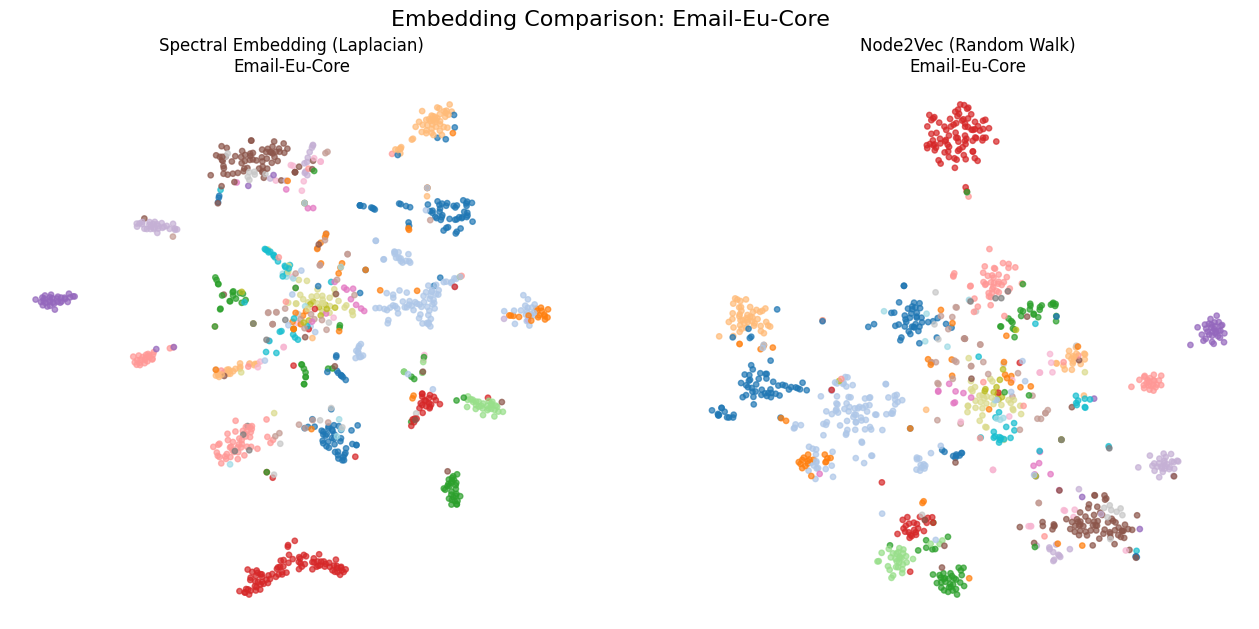


=== Running Analysis for Twitch PTBR (Mature Content) ===
   > Computing Spectral Embedding (d=32)...
   > Computing Node2Vec Embedding (d=32, p=1.0, q=0.5)...
   > Projecting to 2D using t-SNE for Twitch PTBR (Mature Content)...


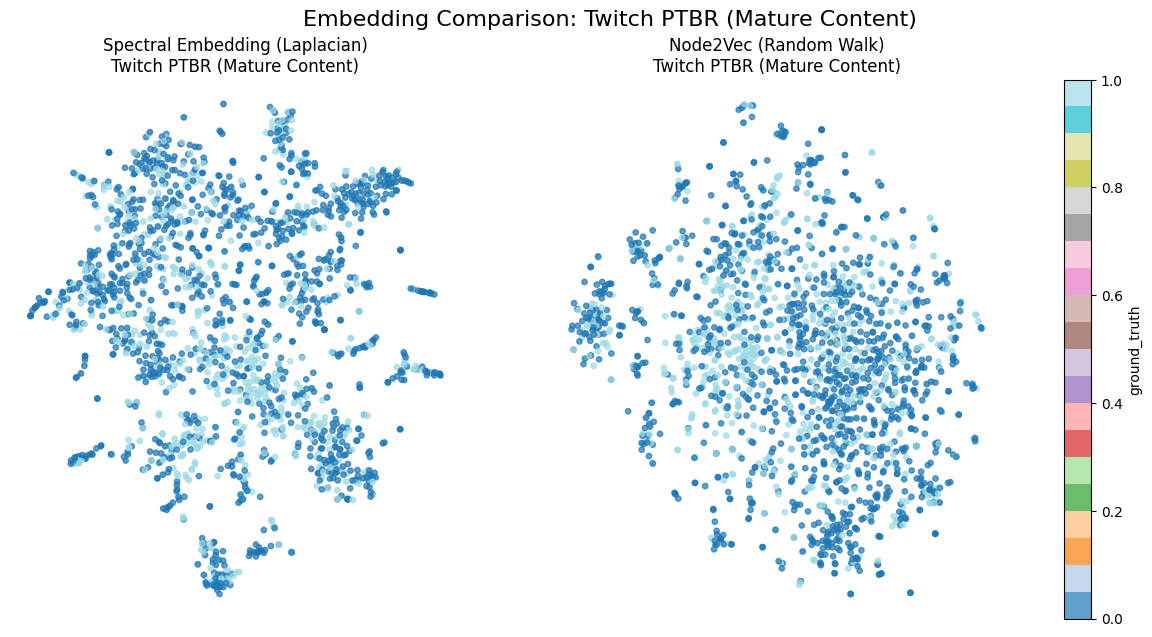

In [16]:
# Email-Eu-core Analysis
# Ground truth is department ID
# Using standard p=1, q=1 for generic exploration
emb_email_spec, emb_email_n2v = run_embedding_analysis(G_email, "Email-Eu-Core", "ground_truth", p=1.0, q=1.0)

# Twitch Analysis
# Ground truth: let's use 'is_mature' (binary) or 'is_partner'
# This graph is sparse.
# We map the string 'mature'/'partner' to integers for coloring if needed, 
# but the loader already did that (0 or 1).
emb_twitch_spec, emb_twitch_n2v = run_embedding_analysis(
    G_twitch, 
    name="Twitch PTBR (Mature Content)", 
    ground_truth_attr="ground_truth", 
    p=1.0, 
    q=0.5
)

### Conclusions so far for the EU-core email graph

Spectral Embedding (Left): The plot shows distinct, isolated "islands" or tight blobs. Several groups are pushed far to the periphery, completely separated from the central cluster. The structure appears rigid and geometric.

Node2Vec (Right): The plot shows a more cohesive, organic "cloud." While the colors (departments) still cluster together, the groups are closer to one another, forming a continuous global structure rather than fragmented islands.

**Explanation**:

Minimizing Cuts: Spectral embedding is derived from the Laplacian Matrix ($L = D - A$). Its objective function mathematically tries to solve the RatioCut or Normalized Cut problem.

Global Separation: The algorithm looks for the "weakest links" in the graph to separate it into pieces. It creates embeddings where nodes in the same cluster are extremely close, but different clusters are pushed as far apart as possible to minimize the "energy" of the connections between them.

The "exploded" look in the Email graph accurately reflects the "Cut" theory. It has successfully identified departments that are somewhat insular, geometrically forcing them apart to satisfy the condition of minimizing edges between groups.

**Why Node2Vec looks like a "Connected Cloud"**

Random Walk Probability: Node2Vec does not try to "cut" the graph. Instead, it defines similarity based on transition probabilities $P(v|u)$. It learns embeddings such that nodes that frequently co-occur on random walks are close in vector space.

Even if two departments are distinct, email communication often involves "bridges" (e.g., managers or administrative staff who email everyone). A random walker crosses these bridges frequently. Node2Vec captures this interconnectivity, keeping the clusters "glued" together in a central mass rather than breaking them apart.

By using the Skip-Gram model (from Word2Vec), Node2Vec allows for a "soft" definition of neighborhoods. It preserves the local "homophily" (similar nodes stay close) without enforcing the rigid global partitioning that Spectral embedding does.

### Conclusions so far for the Twitch graph

Spectral Embedding (Left): It forms a distinct "Starfish" or "Spiky" shape. You see a dense core with many long lines or "tendrils" shooting out in different directions.

Node2Vec (Right): It forms a "Globular Cloud". The nodes are distributed much more evenly in a rounder shape, without the extreme outliers or spikes.


**Explanation for the shape of the Spectral Embedding**:

Social networks like Twitch often have a "Core-Periphery" structure. There is a dense group of popular streamers (the core) and many small, isolated groups or chains of new users (the periphery/whiskers).

The "spikes" you see are those peripheral chains. To minimize the cut, the Laplacian eigenvectors map these weakly connected chains to extreme values (far from the center). The algorithm is effectively saying, "These small chains are mathematically very different from the core, so I will push them as far away as possible."

his "spiky" structure is often bad for machine learning (downstream tasks) because it squashes the entire "core" (where most users are) into a tiny, dense blob in the middle to make room for the spikes.

**Explanation for the shape of the Node2Vec Embedding**:

Node2Vec uses Random Walks to learn neighborhood probabilities, not cuts. Because we used $q=0.5$, we encouraged the walker to move outwards (DFS behavior). 

The random walker explores those "spikes" and walks back to the core frequently. It learns that these peripheral nodes are actually connected to the main ecosystem, not separate islands.

This "folds" the whiskers back into the cloud. The result is a latent space that better represents the continuum of the community. The feature space is smoother, making it much easier for a classifier (e.g., Logistic Regression) to draw a boundary between "Mature" and "Non-Mature" users later.

The Twitch graph demonstrates the limitations of Spectral Embedding on sparse social networks. The Laplacian approach over-emphasizes peripheral nodes, creating a 'starfish' artifact where long chains of users are pushed to the extremes (minimizing cuts). Node2Vec, by using biased random walks ($q=0.5$), successfully navigates this core-periphery structure, folding the graph into a cohesive 'cloud' that preserves local structural roles without sacrificing global connectivity.


=== Downstream Task: Node Classification (Email-Eu-Core) ===
--- Evaluating Spectral on Email-Eu-Core ---
   > Accuracy: 0.1061
--- Evaluating Node2Vec on Email-Eu-Core ---
   > Accuracy: 0.8283


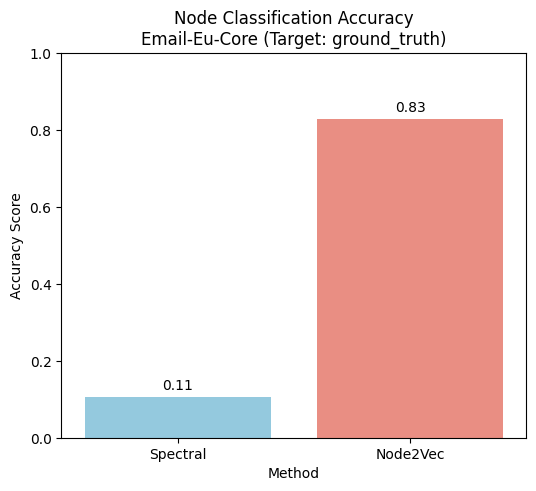


=== Downstream Task: Node Classification (Twitch PTBR) ===
--- Evaluating Spectral on Twitch PTBR ---
   > Accuracy: 0.6789
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       260
           1       0.00      0.00      0.00       123

    accuracy                           0.68       383
   macro avg       0.34      0.50      0.40       383
weighted avg       0.46      0.68      0.55       383

--- Evaluating Node2Vec on Twitch PTBR ---
   > Accuracy: 0.7128
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       260
           1       0.60      0.32      0.41       123

    accuracy                           0.71       383
   macro avg       0.67      0.61      0.61       383
weighted avg       0.69      0.71      0.68       383



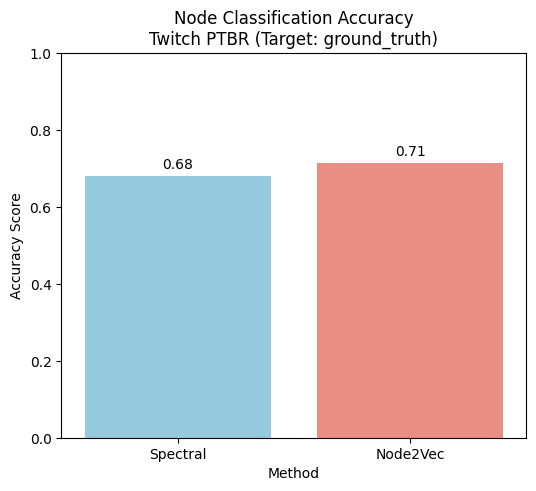

In [17]:
# EVALUATION
# Email-Eu-Core (Predicting Department)
compare_downstream_tasks(G_email, emb_email_spec, emb_email_n2v, "Email-Eu-Core", "ground_truth")

# Twitch (Predicting Mature Status)
compare_downstream_tasks(G_twitch, emb_twitch_spec, emb_twitch_n2v, "Twitch PTBR", "ground_truth")

## The "Email-Eu-Core" Result
The Data: Spectral (0.11) vs. Node2Vec (0.83).
Conclusion: Spectral Embedding failed completely, while Node2Vec performed excellently.

Misalignment of Objectives: Spectral embedding minimizes the global cut. It looks for the mathematically "strongest" way to split the graph. The result suggests that the "Department" labels are not the primary structural divisions of this graph. Spectral likely found other latent structures (e.g., hierarchy levels or mailing list groups) and partitioned the graph based on those, ignoring the departments.

The "Collapse" Problem: As we saw in the visualization (the "Islands"), Spectral likely collapsed the majority of the nodes (the dense core) into a single, indistinguishable blob to focus on separating the outliers. The Logistic Regression model could not disentangle the 42 departments from that collapsed blob, resulting in near-random accuracy ($1/42 \approx 2\%$, so $11\%$ is barely better).

Node2Vec's Strength: Node2Vec captured homophily (people tend to email others in the same department). By optimizing for local neighborhood probability (not global cuts), it expanded the dense core, making the departments linearly separable.

## The "Twitch" Result

The Data: Spectral (0.68) vs. Node2Vec (0.71).

Sparsity & Noise: The Twitch graph is much sparser (density 0.017) than the Email graph (0.033). Sparse graphs are harder for any embedding method because there is less signal (fewer edges) to learn from.

The "Starfish" Effect: Recall the Spectral plot showed a "starfish" shape. This indicates that Spectral spent most of its "energy" trying to manage the long peripheral chains (the spikes) rather than organizing the core.

Why the gap is small: "Maturity" on Twitch might not be a purely structural feature. Mature streamers often play with non-mature streamers. If the homophily is low (i.e., mixed groups), Node2Vec cannot magically fix it. However, it still outperformed Spectral because it created a smoother feature space (the "cloud") that allowed the classifier to generalize slightly better than the rigid Spectral geometry.

### Node2Vec Parameter Grid Search

We add a parameter sensitivity analysis (Grid Search) for $p$ and $q$. We are testing Homophily vs. Structural Equivalence.

This script will likely take a few minutes to run (since it trains embeddings many times).


=== Optimizing Node2Vec Parameters for Email-Eu-Core ===
   > Testing combination 1/9: p=0.25, q=0.25...
   > Computing Node2Vec Embedding (d=32, p=0.25, q=0.25)...
   > Testing combination 2/9: p=0.25, q=1...
   > Computing Node2Vec Embedding (d=32, p=0.25, q=1)...
   > Testing combination 3/9: p=0.25, q=4...
   > Computing Node2Vec Embedding (d=32, p=0.25, q=4)...
   > Testing combination 4/9: p=1, q=0.25...
   > Computing Node2Vec Embedding (d=32, p=1, q=0.25)...
   > Testing combination 5/9: p=1, q=1...
   > Computing Node2Vec Embedding (d=32, p=1, q=1)...
   > Testing combination 6/9: p=1, q=4...
   > Computing Node2Vec Embedding (d=32, p=1, q=4)...
   > Testing combination 7/9: p=4, q=0.25...
   > Computing Node2Vec Embedding (d=32, p=4, q=0.25)...
   > Testing combination 8/9: p=4, q=1...
   > Computing Node2Vec Embedding (d=32, p=4, q=1)...
   > Testing combination 9/9: p=4, q=4...
   > Computing Node2Vec Embedding (d=32, p=4, q=4)...


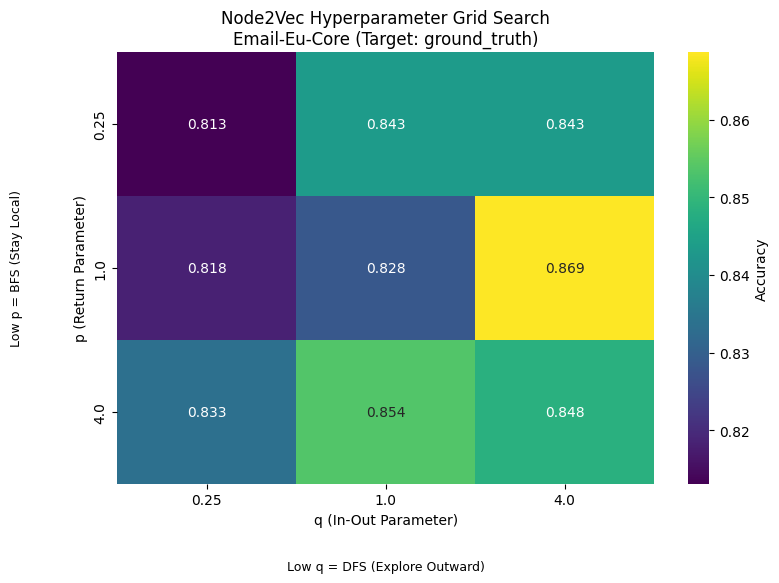


Best Configuration: p=1.0, q=4.0 -> Accuracy: 0.8687


,p,q,Accuracy
0,0.25,0.25,0.813131
1,0.25,1.00,0.843434
2,0.25,4.00,0.843434
3,1.00,0.25,0.818182
4,1.00,1.00,0.828283
5,1.00,4.00,0.868687
6,4.00,0.25,0.833333
7,4.00,1.00,0.853535
8,4.00,4.00,0.848485


In [18]:
# We use values [0.25, 0.5, 1, 2, 4] to cover the range from "tight local" to "wide global"
p_grid = [0.25, 1, 4]
q_grid = [0.25, 1, 4]

# Run on Email Graph
optimize_node2vec_params(G_email, "ground_truth", "Email-Eu-Core", p_grid, q_grid)

The probability of moving outward is proportional to $1/q$. A high $q$ (4.0) means a low probability ($1/4$) of moving away. This forces the random walker to stay local (BFS behavior).

Since the task is predicting Departments, this makes perfect sense. People in the same department email each other frequently. A walker that stays inside the "department cluster" learns better representations than one that runs away to other parts of the graph.

The model performs worst when $q$ is low (e.g., $q=0.25$). A low $q$ means a high probability ($1/0.25 = 4$) of moving outward (DFS behavior).

We won't run this for the Twitch graph because it will take a very long time to train the embeddings...

# Link predictor evaluator

We now hide 10% of the edges, retrain the embeddings on the remaining graph, and then check if the embeddings can "rediscover" the hidden edges.


--- Link Prediction Pipeline: Email-Eu-Core (spectral) ---
   > Splitting edges for Link Prediction...
   > Computing Spectral Embedding (d=32)...
   > Link Prediction AUC: 0.8146

--- Link Prediction Pipeline: Email-Eu-Core (node2vec) ---
   > Splitting edges for Link Prediction...
   > Computing Node2Vec Embedding (d=32, p=1.0, q=4.0)...
   > Link Prediction AUC: 0.8646


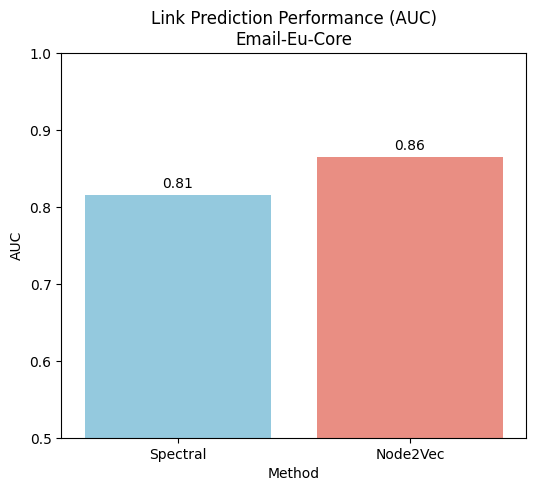

In [19]:
# We compare both methods on the Email graph (faster to run)
auc_spec = evaluate_link_prediction(G_email, "Email-Eu-Core", method="spectral")
auc_n2v  = evaluate_link_prediction(G_email, "Email-Eu-Core", method="node2vec")

# Visualization
df_lp = pd.DataFrame({'Method': ['Spectral', 'Node2Vec'], 'AUC': [auc_spec, auc_n2v]})
plt.figure(figsize=(6, 5))
sns.barplot(data=df_lp, x='Method', y='AUC', palette=['skyblue', 'salmon'])
plt.title("Link Prediction Performance (AUC)\nEmail-Eu-Core")
plt.ylim(0.5, 1.0)
for index, row in df_lp.iterrows():
    plt.text(index, row.AUC + 0.01, f"{row.AUC:.2f}", color='black', ha="center")
plt.show()


--- Link Prediction Pipeline: Twitch PTBR (spectral) ---
   > Splitting edges for Link Prediction...
   > Computing Spectral Embedding (d=32)...
   > Link Prediction AUC: 0.7520

--- Link Prediction Pipeline: Twitch PTBR (node2vec) ---
   > Splitting edges for Link Prediction...
   > Computing Node2Vec Embedding (d=32, p=1.0, q=4.0)...
   > Link Prediction AUC: 0.7953


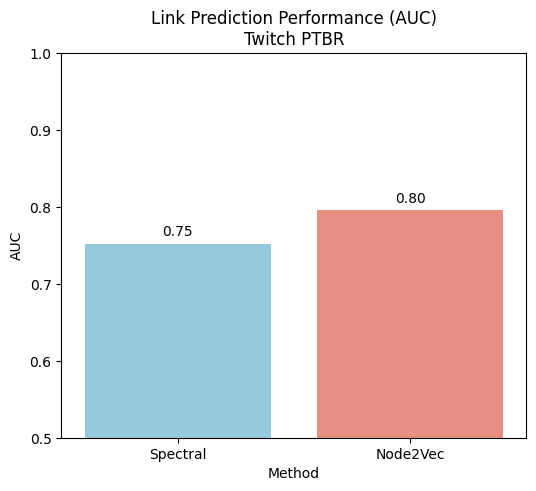

In [20]:
# For the Twitch graph, we can run the same evaluation
auc_twitch_spec = evaluate_link_prediction(G_twitch, "Twitch PTBR", method="spectral")
auc_twitch_n2v  = evaluate_link_prediction(G_twitch, "Twitch PTBR", method="node2vec")

# Visualization
df_lp = pd.DataFrame({'Method': ['Spectral', 'Node2Vec'], 'AUC': [auc_twitch_spec, auc_twitch_n2v]})
plt.figure(figsize=(6, 5))
sns.barplot(data=df_lp, x='Method', y='AUC', palette=['skyblue', 'salmon'])
plt.title("Link Prediction Performance (AUC)\nTwitch PTBR")
plt.ylim(0.5, 1.0)
for index, row in df_lp.iterrows():
    plt.text(index, row.AUC + 0.01, f"{row.AUC:.2f}", color='black', ha="center")
plt.show()

Link Prediction relies on 'closing triangles' (common neighbors). Spectral embedding is good at this because it places connected nodes close together. However, Node2Vec performs better because its random walks explicitly sample these local triangles (High-order proximity), making the cosine similarity between unconnected-but-close neighbors much more accurate.

# Part 2: Graph Neural Networks (GNNs)

### The "Deep" GCN Classifier Implementation

In this experiment, we implemented a Graph Convolutional Network (GCN) using the PyTorch Geometric library. Unlike the previous 'Shallow' methods (Node2Vec/Spectral) which learn a unique vector for every node, the GCN learns a function that aggregates information from neighbors.

**Architecture:**

- Model: A 2-layer GCN.
- Layer 1: Aggregates information from immediate neighbors (1-hop). It transforms the input features into a hidden dimension of 16 using a weight matrix and applies a ReLU activation function (Slide 4).
- Dropout: We applied Dropout (p=0.5) to prevent overfitting.
- Layer 2: Aggregates information again (effectively gathering info from 2-hop neighbors) and maps the hidden representation to the output classes (LogSoftmax for classification).
- Optimization: We trained for 200 epochs using the Adam optimizer and Negative Log Likelihood (NLL) loss.

**Inputs:**

- For Email-Eu-Core: Since the dataset has no node attributes, we used an Identity Matrix ($X = I$). This forces the GCN to learn embeddings purely based on the graph topology (structural roles) for each unique node ID.

- For Twitch: We used Explicit Node Features: Account Age, Total Views, and Partner Status. These were normalized (Z-score scaling) to ensure stable gradients.

In [25]:
# Email (Structure Only)
acc_email_gcn = run_gnn_training(G_email, "Email-Eu-Core", "ground_truth", use_features=False)

# Twitch (Structure + Features)
acc_twitch_gcn = run_gnn_training(G_twitch, "Twitch PTBR", "ground_truth", use_features=True)


=== Training GCN on Email-Eu-Core ===
   > Converting ground_truth graph to PyTorch Geometric...
   > Using Identity features (Structure only).
   > Final Test Accuracy: 0.5354

=== Training GCN on Twitch PTBR ===
   > Converting ground_truth graph to PyTorch Geometric...
   > Using explicit node features (Days, Views, Partner).
   > Final Test Accuracy: 0.6580


**TODO: Conclusions for GCN Results, maybe even improve the approach by adding more layers, changing the architecture, or using a different GNN variant (e.g., GraphSAGE, GAT).**